# Fast Fourier Transform for Software Defined Radio 
### Overview
The [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform#:~:text=A%20fast%20Fourier%20transform%20(FFT,frequency%20domain%20and%20vice%20versa.) (FFT) is used repeatedly in the digital signal processing (DSP) of software defined radios (SDRs).  This ipython notebook is an attempt to make the FFT understandable for SDR users. It is specially written for my Electronics II students who are designing and building quadrature sampling detector (QSD) SDRs whose outputs feed the software part of the SDR in a computer through the sound card.  [Konrad McCLure's video on how the quadrature sampling detector works,](https://youtu.be/UoL1Qzaw2H0?t=192) is worth watching again, as it contains the background information you need, to understand the signals which enter the sound card.  It will also help you understand the DSP which occurs inside the computer, because both processes involve throwing out an infinite amount of information to retain what we really care about, and the periodic snapshots analogy is also useful understanding how that works.  A [gnuradio flowgraph](https://fweb.wallawalla.edu/~frohro/ClassHandouts/Electronics/SDR-RX.grc) is also provided to demodulate [single sideband](https://en.wikipedia.org/wiki/Single-sideband_modulation) (SSB) signals from a QSD SDR.  Examining this flowgraph shows how the FFT is used over and over again in the DSP it does.  As an example to make this description more concrete we will describe the process used to create the waterfall and spectral displays often seen in SDRs.

### Fourier Series
A radio signal is a well behaved function, and can be seen from two perspectives.  The first one is what shows up on the oscilloscope, or a graph with the independent variable (horizontal axis) being time .  The second way was discovered and/or popularized by Joseph Fourier, known mathematically as the [Fourier series](https://en.wikipedia.org/wiki/Fourier_series).  It is basically the idea that given a time interval, we can express any "reasonable" function in that time interval as a linear combination (weighted sum) of harmonic sinusoids whose periods are coincident with that interval.  Each sinusoid has a specific amplitude and is delayed a specific amount so that when you add them all up and graph the result in time, you have the first way of describing the radio signal.  Both ways of describing the signals are useful.  It should be stressed that the signal is the same; there are just these two useful ways of organizing the information the signal carries, or in other words, of describing the radio frequency signal we wish to listen to with our radio receiver. As an example, the python code below shows you how with just a few sinusoids, you can make a pretty good approximation of a square wave.

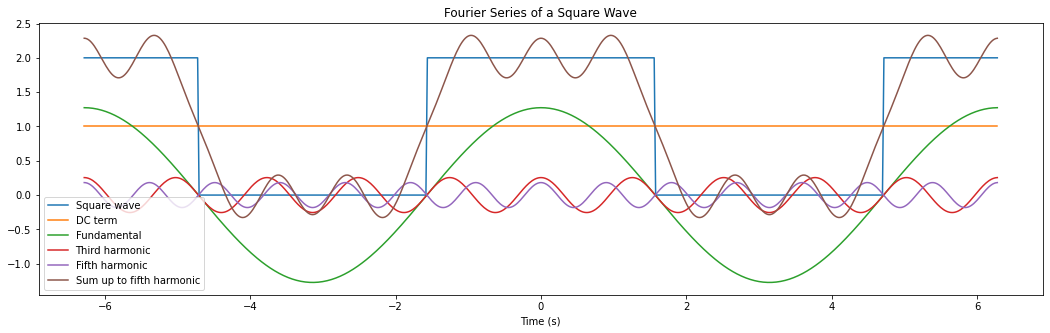

In [1]:
# Python script to calculate and plot the Fourier Series for sgn(cos(t))+1
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [18, 5]

t = np.arange(-2*np.pi,2*np.pi, 0.02)
plt.plot(t, np.sign(np.cos(t))+1, t, np.ones(np.size(t)), t, 4/np.pi*np.cos(t), t, 4/5/np.pi*np.cos(5*t), 
         t, 4/7/np.pi*np.cos(7*t), t, 
         1 + 4/np.pi*np.cos(t) - 4/3/np.pi*np.cos(3*t) + 4/5/np.pi*np.cos(5*t) + 4/7/np.pi*np.cos(7*t))
plt.legend(['Square wave', 'DC term', 'Fundamental', 'Third harmonic','Fifth harmonic', 
            'Sum up to fifth harmonic'])
plt.xlabel('Time (s)')
plt.title('Fourier Series of a Square Wave')
plt.show()

Note how each sinusoid is periodic with the same period the square wave has.  

### Information in Our Radio Signals
The information we care about in our radio frequency signal is finite, because we can't hold an infinite amount of information in a computer or our brain.  This means we need to select from the infinite amount of information the signal contains, only the parts we care about.  What are these?  
* First, we only care about the signal over a finite time interval (only while we are listening).  
* Second, we want to listen to only one radio station during this time interval, which means only a limited band of frequencies are of interest.  
* Third, we do not need infinite precision on any of our measurements. 

We desire to keep only the information we care about, but still be able to organize it in time sequential fashion, or as a collection sinusoids.  The graphs above give us hope.  Our time interval of interest could be one period of the square wave, and realizing the plot above is made up of individual pixels on the screen, we only need a finite number of time measurements.  Maybe we could just keep the first few or most important harmonic sinusoids as well, so both ways of looking at the data only require a finite amount of data.  Time measurements could sampled every so often, using an analog to digital converter, or if we prefered to measure harmonics instead, we could construct a bank of bandpass filters, spaced out evenly over our band of frequencies, and measure the amplitude and phase outputs of each of them to represent the wave.  We only need to pick one or the other of these measurement methods to collect the information about the signal we desire, because it should be possible to reorganize that information to view it from either perspective, and maybe the computer could do that work for us.

As a side note, representing this function this way, assumes that we don't care what happens outside our interval, or that what happens inside the interval is repeated over and over outside our interval.  In our case, we just have to remember that this way of looking at the signal will give us values of our signal in the future and the past both before and after we started recording our signals, but those, of course, are only because writing our signal as a sum of periodic sinusouds assumes everything is repeating, because sine waves do.

### What the QSD SDR Does to the Radio Frequency Signal
Because it is cheaper and more flexible, the periodic time sampling way is normally used, so we use it in our QSD SDR receivers.  To make this process easier, the QSD circuit translates the band of frequencies of our radio station of interest down to audio frequencies whose sine waves are slowly varying.  The "dot to dot" interpretation of our data allows us to get by with significantly fewer samples per second this way.

#### How Fast Must We Sample?
Two signals from the QSD enter the two channels (left audio capture and right audio capture) of the sound card. The sound card does the analog to digital conversion to change these signals into a set of signal measurements occurring every $T$ seconds, or uniformly timed data occurring $f_s = 1/T$ times a second. Essentially, what happens is an infinite amount of information is discarded so the remaining information will fit in the finite memory available in the computer.  The assumption needed to do this is that a "dot to dot" interpretation of the resulting measurements is correct.  This is basically the same as assuming the signals go smoothly between each data point, not going up and down between them, or more generally, they just don't change rapidly (have high frequency components to them).  In the propeller example, it is like saying the propeller is going slowly, more precisely, it is not going around even half a cycle in the time between measurements, $T$.  

As Konrad has shown, the radio frequency (RF) signal is sampled into two signals, called in-phase (I), and quadrature (Q).  The QSD sampling and low pass filtering process shifts the RF signal down to the audio range, producing the intermediate frequency (IF) I and Q signals.  The I signal is the same phase as the RF signal, and the Q signal is delayed by 90 degrees.  Frequencies higher than audio are filtered out by the QSD, and the sound card also assists in this filtering process, so the I and Q signals only contain components with frequencies in the audio range. Their frequency spectrum (as seen on a spectrum analyzer) looks identical to the RF frequency spectrum centered on the local oscillator (LO) frequency of your SDR hardware, simply shifted down so the LO frequency in the RF signal looks identical to the DC signal in the I or Q signals.  All the other frequencies not close to the LO frequencies are removed by the low pass filtering built into the QSD process.  This process the QSD does for us eliminates an infinite amount of information and energy we don't care about (all the other radio stations we don't want to listen to), and it shifts the RF signal down to the audio spectrum where it is changing slowly.  

It is imperative that frequencies greater than or equal to half the sampling frequency are not present in the analog signals to be converted to digital or they will be misinterpreted.  This is illustrated below.

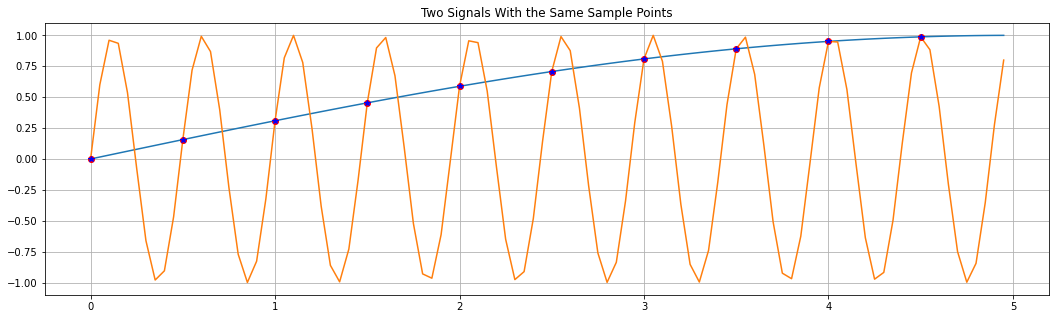

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 10
N_cont = 10*N
T = .5
f = .05
def signal_comparison(N, N_cont, T, f):
    t_samp = np.arange(N)*T
    t_cont = np.arange(N_cont)*T*(N/N_cont)
    x1_cont = np.sin(2*np.pi*f*t_cont)
    x2_cont = np.sin(2*np.pi*(f+1/T)*t_cont)
    x1 = np.sin(2*np.pi*f*t_samp)
    x2 = np.sin(2*np.pi*(f+1/T)*t_samp)
    return t_cont, t_samp,x1_cont, x2_cont, x1, x2
t_cont, t_samp, x1_cont, x2_cont, x1, x2 = signal_comparison(N, 
        N_cont, T, f)
plt.plot(t_cont, x1_cont, t_cont, x2_cont, t_samp, x1, 'ro', 
         t_samp, x2, 'b*')
plt.grid()
plt.title('Two Signals With the Same Sample Points')
plt.show()

Fortunately, the QSD threw out all the data that would have caused the propeller to spin around more than one half a cycle per snapshot.  Only slowly varying data (audio frequencies) remains after the QSD.  If you think about a sine wave, and try to visualize the slowest you could sample it and still reproduce it with the lowest frequency sine wave using the "dot to dot" method, you would come up with the equation $f_s \leq 1/(2T)$.  If you picked exactly two points per cycle, you might sample when the sine wave went through zero every time, and you would think it was zero, but it wasn't. 😀  The QSD insures we have more that two snapshots for the fastest sine wave in our signal.

### The Complex Intermediate Frequency Signal
Now that we understand we need to sample fast enough, and the QSD makes that possible, we need to think about making a graph that shows how much of each frequency component we have in our signal.  This is the spectrum diagram on top in the Quisk display below. The waterfall diagram is just the spectral diagram as it is repeatedly measured over time where color is used to signify signal strength instead of height.  It is the lower diagram below in Quisk
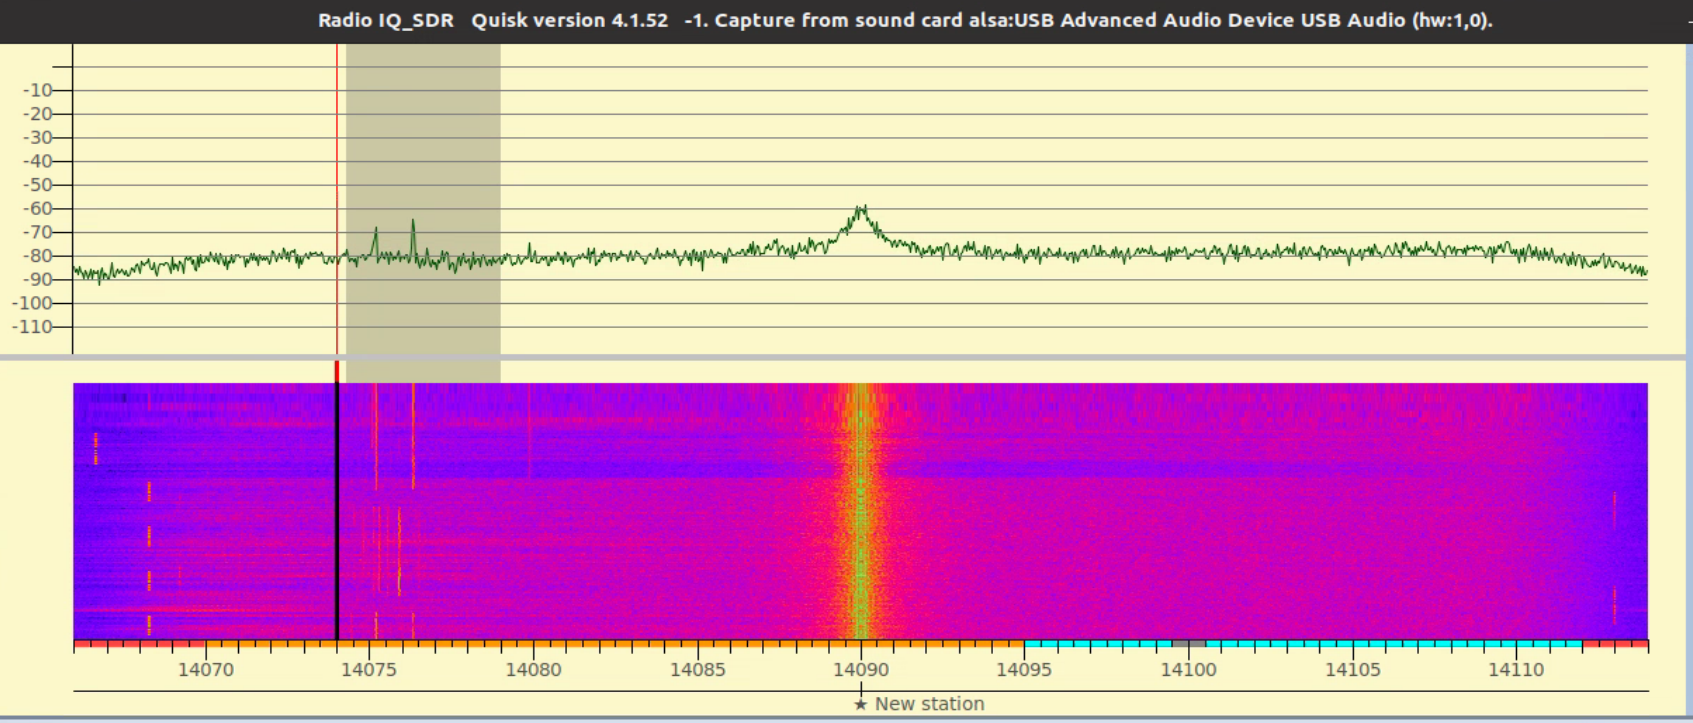

The I and Q signals allow us to simplify the block diagram of the software by considering them together as one complex number.  The I signal is the real part of this new complex signal, and the Q signal is the imaginary part of this complex signal.  See the gnuradio signal flow graph below, where the blue lines represent the complex signal, and the orange ones the individual I or Q signals.  Note how they both get processed simultaneously, and how the complex representation simplifies the diagram. 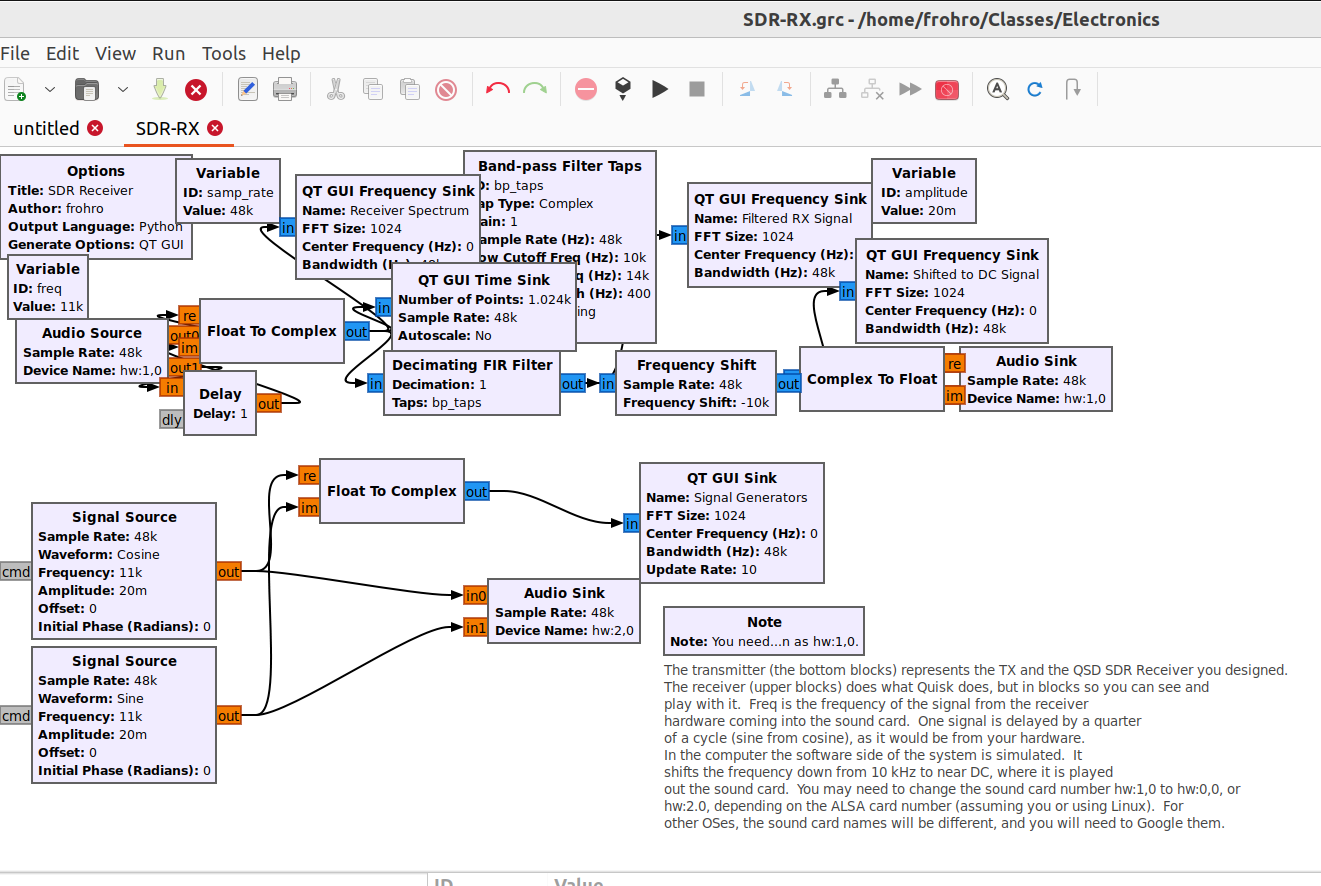

This way of writing the signal we care about is based on Euler's identity.  $cos(2\pi f t) + j sin(2\pi f t) = e^{j2\pi f t}$. The parameter, $f$ tells how many cycles per second the complex signal spins around the origin in the counterclockwise direction per second.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation
import matplotlib.ticker as plticker
import numpy as np
from IPython.display import HTML

T = 1
N = 8
f_0 = 1/(8*T)
T_0 = N*T
f_s = 1/T

M = 8  # This is the number of points between samples for the "continuous curve."
t_n = np.linspace(0, T_0, N+1)
t = np.linspace(0, T_0, M*N+1)
x_n = np.cos(2*np.pi*f_0*t_n)
y_n = np.sin(2*np.pi*f_0*t_n)
x = np.cos(2*np.pi*(f_0)*t)
y = np.sin(2*np.pi*(f_0)*t)
x_1 = np.cos(2*np.pi*(f_0-f_s)*t)
y_1 = np.sin(2*np.pi*(f_0-f_s)*t)

fig, ax = plt.subplots(nrows=2, ncols=2,
                       gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, figsize=(8, 8));
#plt.close();
ax[0][0].set_aspect(1)
ax[0][0].axis([-1, 1, -1, 1])
# ax[0][1].set_aspect(1)
# ax[1][0].set_aspect(1)
ax[0][1].axis([0, T_0, -1, 1])
ax[1][0].axis([-1, 1, 0, T_0])
ax[1][1].axis('off')
x_title = '$\mathscr {Re}[e^{j2\pi f t}]$'
y_title = '$\mathscr {Im}[e^{j2\pi f t}]$'
x_label = '$\mathscr {Re}$'
y_label = '$\mathscr {Im}$'
t_label = 't (s)'
ax[0][0].set_xlabel(x_label)
ax[0][1].set_xlabel(t_label)
ax[1][0].set_xlabel(x_label)
ax[0][0].set_ylabel(y_label)
ax[0][0].xaxis.set_label_position("top")
ax[0][0].xaxis.tick_top()
ax[0][1].yaxis.set_label_position("right")
ax[0][1].yaxis.tick_right()
ax[1][0].yaxis.set_label_position("right")
ax[1][0].yaxis.tick_right()
axis_linewidth = 0.75
real_color = 'red'
im_color = 'green'
complex_color = 'brown'
real1_color = 'blue'
im1_color = 'red'
complex1_color = 'chartreuse'
ax[0][0].axhline(0, color=real_color, linewidth=axis_linewidth)
ax[0][0].axvline(0, color=im_color, linewidth=axis_linewidth)
ax[0][1].axhline(0, color='black', linewidth=axis_linewidth)
ax[1][0].axvline(0, color='black', linewidth=axis_linewidth)
ax[0][0].set_title('$e^{j\omega t}$')

ax[0][1].set_title(y_title)
ax[1][0].set_title(x_title)

# l10, = ax[0][0].plot([], [], '*', color='black')
# l2, = ax[0][1].plot([], [], '*', color='black')
# l3, = ax[1][0].plot([], [], '*', color='black')
l4, = ax[0][1].plot([], [], '-', color= im_color)
l5, = ax[1][0].plot([], [], '-', color=real_color)
l6, = ax[0][1].plot([], [], '-', color=im1_color)
l7, = ax[1][0].plot([], [], '-', color=real1_color)
l9, = ax[0][0].plot([], [], '-', color=complex_color)
l1, = ax[0][0].plot([], [], '-', color=complex_color)
ax[0][1].legend([l4],[y_title])
ax[1][0].legend([l5],[x_title])

#print('Before animate')
def animate(i):
    l1.set_data(x[:i], y[:i])
    l4.set_data(t[:i], y[:i])
    l5.set_data(x[:i], t[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t), interval=200);
ani.save('phasor.gif', writer='imagemagick')
print('Done!')
plt.close()


Done!


![](phasor.gif)

The plot above shows how the I and Q signals for a frequency component of the complex signal at $f$ make up a circle on the complex plane, making Euler's identity more graphical.  Note how positive frequencies circle counterclockwise, and negative frequencies circle clockwise, and how sampling the complex signal fits nicely into the snapshot propeller analogy in a more concrete way.  I highly recommend you watch this [3Blue1Brown video on the Complex Fourier Series](https://youtu.be/r6sGWTCMz2k).  It shows how you can represent any complex signal (including the positive frequency part of our radio signal of interest) as a complex linear combination of these complex exponentials.  You may be confused by my statement about the positive frequency components of our original signal.  The original radio frequency signal before it was processed by the QSD was a real function.  Real functions are made up of sine waves and cosine waves.  Each of these waves is actually the sum of two complex exponentials, each the complex conjugate of each other, for example,
$$2 cos(2 \pi ft) =  e^{j2 \pi ft} +  e^{-j2 \pi ft}$$
which can be seen graphically in the video above [here](https://youtu.be/r6sGWTCMz2k?t=585).  Note how the complex exponential with negative frequency (clockwise spin) is just the complex conjugate of the one with the one with positive frequency (counterclockwise spin).  This means it is really only necessary to know the positive frequency part of the signal, because given it, you know what the negative one is too.  There are still two numbers to know though, the real and imaginary amplitudes of the positive frequency complex exponential, so no free lunch here.  Still with a real signal it is only necessary to know the positive frequency components of that signal. 

#### What Quisk is Plotting
In your SDR receiver hardware, the positive frequency components of the original radio frequency signal centered on the LO frequency are translated down to DC by the QSD.  The result of that translation, the I and Q signals, can be made into the complex IF signal, $c_{IF}(t) = I(t)+jQ(t)$, by just considering them to be the real and imaginary parts of the complex IF signal.  The complex IF signal, $c_{IF}(t)$ has identical frequency components to the original RF signal, simply moved down in frequency by the local oscillator frequency, $f_{LO}$, so they are centered on DC (0 Hz) instead of the LO frequency. $$f_{IF} = f_{RF}-f_{LO}$$  The parts of the complex IF signal $c_{IF}(t)$ with positive frequency, $f$, were above the LO frequency by $f$ in the positive frequency components of the original radio frequency (RF) signal and those with negative frequency, $-f$ were below the LO frequency by $f$ Hz.  Also note the negative and positive frequency components of $c_{IF}(t)$ are not complex conjugates of each other.  The function $c_{IF}(t)$ is fully complex, a construct for signal processing.  What Quisk is plotting above is actually the frequency components in $c_{IF}(t)$ with a frequency axis scale that has been translated up by $f_{LO}$, because it assumes your QSD did its job correctly.

When you sample $c_{IF}(t)$ every $T$ seconds the result looks like what you see below.  You can now see how the dot to dot analogy gives you something more like what you have above for the $c_{IF}(t)$.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.ticker as plticker
import numpy as np
from IPython.display import HTML

t = np.linspace(0, 2)
x = np.cos(np.pi*t)
y = np.sin(np.pi*t)
fig, ax = plt.subplots(nrows=2, ncols=2,
                       gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, figsize=(8, 8));
plt.close();
ax[0][0].set_aspect(1)
ax[0][0].axis([-1, 1, -1, 1])
ax[0][1].set_aspect(1)
ax[1][0].set_aspect(1)
ax[0][1].axis([0, 2, -1, 1])
ax[1][0].axis([-1, 1, 0, 2])
ax[1][1].axis('off')
x_title = '$\mathscr {Re}[e^{j\omega t}]$'
y_title = '$\mathscr {Im}[e^{j\omega t}]$'
x_label = '$\mathscr {Im}$'
y_label = '$\mathscr {Re}$'
t_label = 't (s)'
ax[0][0].set_xlabel(x_label)
ax[0][1].set_xlabel(t_label)
ax[1][0].set_xlabel(x_label)
ax[0][0].set_ylabel(y_label)
ax[0][0].xaxis.set_label_position("top")
ax[0][0].xaxis.tick_top()
ax[0][1].yaxis.set_label_position("right")
ax[0][1].yaxis.tick_right()
ax[1][0].yaxis.set_label_position("right")
ax[1][0].yaxis.tick_right()
axis_linewidth = 0.75
real_color = 'cyan'
im_color = 'magenta'
complex_color = 'green'
ax[0][0].axhline(0, color=real_color, linewidth=axis_linewidth)
ax[0][0].axvline(0, color=im_color, linewidth=axis_linewidth)
ax[0][1].axhline(0, color='black', linewidth=axis_linewidth)
ax[1][0].axvline(0, color='black', linewidth=axis_linewidth)
ax[0][0].set_title('$e^{j\omega t}$')
ax[0][1].set_title(y_title)
ax[1][0].set_title(x_title)
loc = plticker.MultipleLocator(base=1.0)
for i in range(len(ax)):
    for j in range(len(ax[0])):
        ax[i, j].xaxis.set_major_locator(loc)
        ax[j, i].yaxis.set_major_locator(loc)
l1, = ax[0][0].plot([], [], '.', color=complex_color)
l2, = ax[0][1].plot([], [], '.', color=im_color)
l3, = ax[1][0].plot([], [], '.', color=real_color)
ax[0][1].legend([l2],[y_title])
ax[1][0].legend([l3],[x_title])

def animate(i):
    l1.set_data(x[:i], y[:i])
    l2.set_data(t[:i], y[:i])
    l3.set_data(x[:i], t[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t), interval=200);

HTML(ani.to_html5_video())  # For just the animation, no controls.
#HTML(ani.to_jshtml())  # Animation with controls.

#### How Many Frequency Components Should We Keep?
How many complex exponentials do we need to represent our RF signal?  Suppose we have collected $N$ samples in our listening time, $NT$. We need to decide how many and what points we need in frequency space to represent this signal using Fourier's ideas.  The frequencies we can use, assuming the dot to dot interpretation, lie between $-f_s/2$ and $f_s/2$, meaning $-f_s/2 < f < f_s/2$.  The signal is a vector with a $N$ dimensions, because you can think of each measurement as a length of one component of an N dimensional vector.  You can write that vector in terms of different orthogonal coordinate systems.  The original way we sampled the signal by measuring every $T$ seconds is the time coordinate system, and the one we wish we had was the frequency coordinate system.  That could have been had by having a bank of bandpass filters, that we simultaneously applied the incoming signal to, and then measured the amplitude and phase of each of the outputs of those filters.  Fortunately, even without that bank of filters and its measurements, we still have all the information to find what we would have measured with the filters.   The number of dimensions (number of samples we took) for the time signal vector should be equal to the number of dimensions (number of bandpass filtered frequency bins in frequency) since they represent the same vector.  Since we have $N$ points in time, there should be $N$ points in frequency.

If we want $N$ frequency "bins" to divide all the possible frequencies into, each bin will be $f_s/N = 1/(NT)$ Hz wide if we do the simple thing and evenly space them out.  In order to resolve the difference in frequency for two adjacent bins, you must observe the sine wave in time for at least $NT$ seconds. The graph below helps you to see this.  It shows you the difference between a sine wave at $(N-1)/(NT)$ Hz and $(N-2)/(NT)$ Hz for $N=10$.  Note there are nine peaks, $(N-1)$, on the faster wave and eight peaks, $(N-2)$, on the next frequency down.  By picking the center frequencies of the bins this way, we have sine waves that are all periodic over the sampling interval $NT$.  They would extend from $-f_s/2 = -1/(2T)$ to $f_s/2=1/(2T)$ spaced out equally every $1/(NT)$ Hz.  This has a nice symmetry with the same signal in time which is spread over $NT$ seconds, with $N$ samples occurring every $T$ seconds.

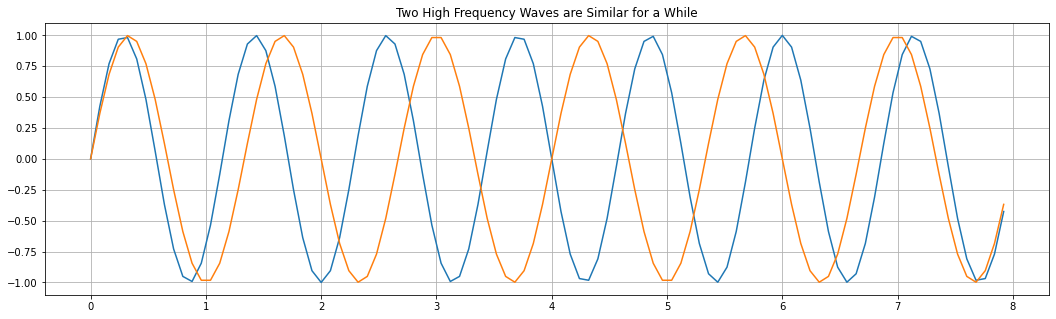

In [5]:
f1, f2 = (N-1)/N/T, (N-2)/N/T
t_cont, t_samp, x1_cont, x2_cont, x1, x2 = signal_comparison(N, 
        N_cont, T, f1)
t_cont, t_samp, x2_cont, junk, x1, x2 = signal_comparison(N, 
        N_cont, T, f2)
plt.plot(t_cont, x1_cont, t_cont, x2_cont)
plt.grid()
plt.title('Two High Frequency Waves are Similar for a While')
plt.show()

Now, we have been hoping several things in saying that we should be able to write the signal in time or frequency interchangeably in such a way that changing is just like a coordinate rotation.  One is that no sinusoid of one frequency can be made up of a linear combination of sinusoids of other frequencies. I think you will agree this is true. This is like saying the vectors in the frequency are orthogonal to each other.  Another is that a set of $N$ complex exponentials, $e^{j2\pi nk/N}$ will suffice to approximate the original time signal as well as the $N$ sample measurements made every $T$ seconds did.  This may be a little harder, but I think you will at least agree it is probably a reasonable approximation.

### How Can We Calculate the Coefficients of the Complex Exponentials in the Fourier Series?
Answering this question could entail a lot of elegant mathematics, and if you remember your linear algebra, it is really pretty simple, but I'll spare you that.  All you have to do is to use the FFT, something like [this](https://gist.github.com/jedludlow/3919130).  Be sure to read it carefully, or you will not interpret the FFT correctly.  A tricky thing you have to do is the np.fft.fftshift operation to get the frequency components in the proper order. This is needed because of the way frequencies are conventionally indexed.  You will learn all about this in Signals & Systems next year.  Another thing you need to realize is that the magnitude of the complex FFT result gives you the amplitude of the frequency component of the signal at the corresponding frequency and this is what you see in the spectrum and waterfall diagrams above. All this is taken care of for you in Quisk, and even gnuradio. 